In [407]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

pd.options.display.float_format = '{:,.2f}'.format

# Setting pandas dataframe display options
pd.set_option("display.max_rows", None)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

In [408]:
def compute_portfolio(quotes, weights, rebalance='yearly', start_amount=100):
    from datetime import datetime
    from dateutil.relativedelta import relativedelta

    Start = quotes.index[0]
    End = quotes.index[-1]
    more_than_year = pd.to_datetime(Start) + relativedelta(months=12) < pd.to_datetime(End)
    more_than_quarter = pd.to_datetime(Start) + relativedelta(months=3) < pd.to_datetime(End)
    more_than_month = pd.to_datetime(Start) + relativedelta(months=1) <= pd.to_datetime(End)

    returns_all = pd.DataFrame()
    quotes_pesos_all = pd.DataFrame()
    weights_all = pd.DataFrame()
    n = -1
    
    if rebalance == 'yearly' and more_than_year:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='A')
    elif rebalance == 'yearly':
        rebalance_dates = pd.to_datetime([End])
    elif rebalance == 'quarterly' and more_than_quarter:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='Q')
    elif rebalance == 'quarterly':
        rebalance_dates = pd.to_datetime([End])    
    elif rebalance == 'monthly' and more_than_month:
        rebalance_dates = pd.bdate_range(start=Start, end=End, freq='M')
    elif rebalance == 'quarterly':
        rebalance_dates = pd.to_datetime([End])
    elif rebalance == False:
        rebalance_dates = pd.to_datetime([End]) 
    

    for i in np.arange(len(rebalance_dates)):
        n+=1
        break_point_future = rebalance_dates[n]
        break_point_past = rebalance_dates[n-1]
        # Até ao primeiro breakpoint
        if n == 0:
            quotes_norm_periodo = pl.normalize(quotes[:break_point_future])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])
        # # Break points a seguir
        if n > 0 and n < len(rebalance_dates):
            quotes_norm_periodo = pl.normalize(quotes[break_point_past:break_point_future])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])
        # last break point
        if n == len(rebalance_dates) - 1:
            # print(n)
            quotes_norm_periodo = pl.normalize(quotes[break_point_future:])
            quotes_pesos_periodo = quotes_norm_periodo * np.array(weights)
            quotes_pesos_periodo_soma = quotes_pesos_periodo.sum(axis=1)
            returns_periodo = quotes_pesos_periodo_soma.pct_change().dropna()
            returns_all = pd.concat([returns_all, returns_periodo])
            weights_all = pd.concat([weights_all, quotes_pesos_periodo])
            quotes_pesos_all = pd.concat([quotes_pesos_all, quotes_pesos_periodo])

    portfolio = pl.normalize(pl.compute_time_series(returns_all)) * (start_amount/100)
    portfolio = portfolio[~portfolio.index.duplicated(keep='first')]
    weights_all = weights_all[~weights_all.index.duplicated(keep='first')]
    quotes_pesos_all = quotes_pesos_all[~quotes_pesos_all.index.duplicated(keep='first')]
    weights_all = weights_all.div(weights_all.sum(axis=1), axis=0)
    weights_all = weights_all[:-1]
    
    return portfolio, weights_all, quotes_pesos_all

In [409]:
data = pd.DataFrame(pd.read_excel('ie_data.xls', sheet_name='Data', header=6).iloc[1:-1,:2])

# Continuação
data['Unnamed: 0'] = data['Unnamed: 0'].astype('float')
data['Unnamed: 0'] = data['Unnamed: 0'].apply(lambda x: "{:.2f}".format(x))
data['Unnamed: 0'] = data['Unnamed: 0'].astype(str)
data['Comp.'] = data['Comp.'].astype('float')
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'], format='%Y.%m').dt.strftime('%Y-%m')
data.columns = ['Date', 'S&P Composite']
data.set_index('Date', inplace=True)
data = data.sort_values(by='Date')
SP = data.copy()

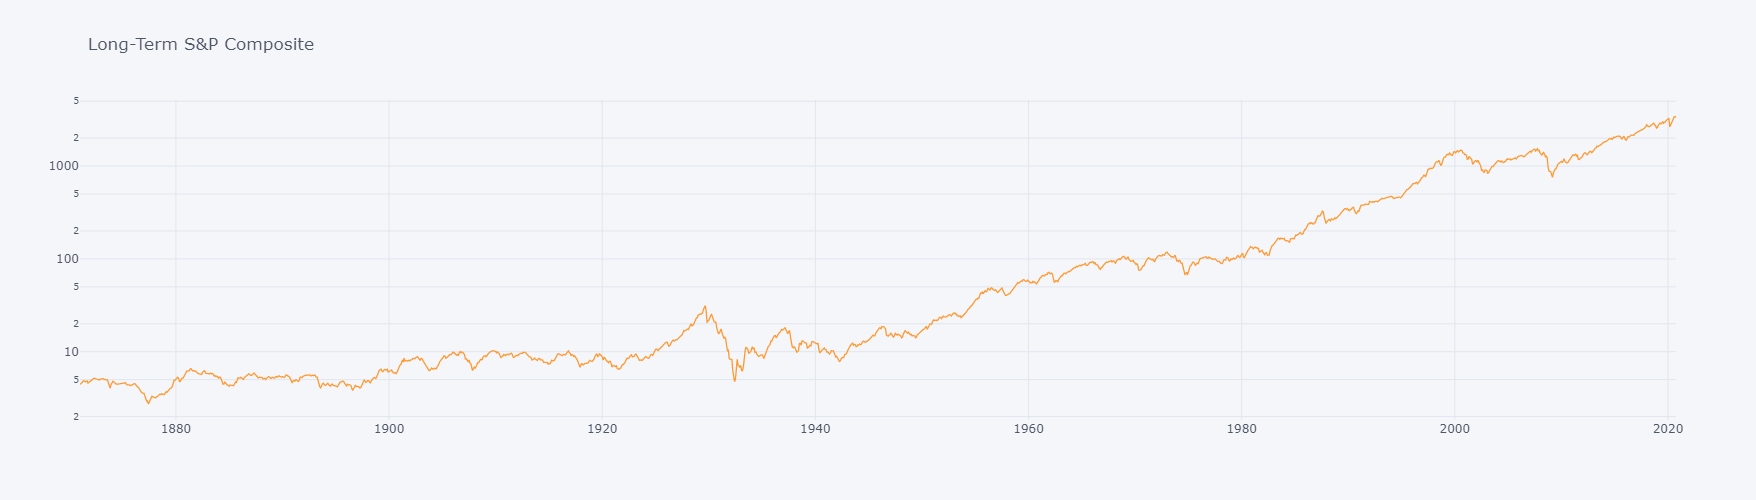

In [410]:
data.iplot(dimensions=(1000, 500), logy=True, title = 'Long-Term S&P Composite')

In [411]:
from dateutil import parser

dates = ['January 1 1871', 'March 4, 1877', 'March 4, 1881', 'September 19, 1881', 'March 4, 1885', 'March 4, 1889', 'March 4, 1893', 'March 4, 1897', 'September 14, 1901', 'March 4, 1909', 'March 4, 1913', 'March 4, 1921',
        'August 2, 1923', 'March 4, 1929', 'March 4, 1933', 'April 12, 1945', 'January 20, 1953', 'January 20, 1961', 'November 22, 1963', 'January 20, 1969', 'August 9, 1974', 'January 20, 1977',
        'January 20, 1981', 'January 20, 1989', 'January 20, 1993', 'January 20, 2001', 'January 20, 2009', 'January 20, 2017']
len(dates)

datetime_list = []

for date in dates:
    datetime_list.append(parser.parse(date))

In [412]:
presidents  = ['Ulysses S. Grant', 'Rutherford B. Hayes', 'James A. Garfield', 'Chester A. Arthur', 'Grover Cleveland',
               'Benjamin Harrison', 'Grover Cleveland', 'William McKinley', 'Theodore Roosevelt', 'William Howard Taft.',
               'Woodrow Wilson', 'Warren G. Harding', 'Calvin Coolidge', 'Herbert Hoover', 'Franklin D. Roosevelt',
               'Harry S. Truman', 'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson', 'Richard Nixon',
               'Gerald Ford', 'Jimmy Carter', 'Ronald Reagan', 'George H. W. Bush', 'Bill Clinton',
               'George W. Bush', 'Barack Obama', 'Donald Trump']
len(presidents)

28

In [413]:
affiliation = ['Republican', 'Republican', 'Republican', 'Republican', 'Democratic',
               'Republican', 'Democratic', 'Republican', 'Republican', 'Republican',
               'Democratic', 'Republican', 'Republican', 'Republican', 'Democratic',
               'Democratic', 'Republican', 'Democratic', 'Democratic', 'Republican',
               'Republican', 'Democratic', 'Republican', 'Republican', 'Democratic',
               'Republican', 'Democratic', 'Republican']

len(affiliation)

28

In [414]:
data = pd.DataFrame([datetime_list, datetime_list, presidents, affiliation]).transpose()
data.columns = ['Start Date', 'End Date', 'Name', 'Party']
data['End Date'] = data['End Date'].shift(-1)
data['End Date'].iloc[-1] = pd.to_datetime('2020-10-31')
# data.set_index('Start Date', inplace=True)
data

,Start Date,End Date,Name,Party
0,1871-01-01,1877-03-04,Ulysses S. Grant,Republican
1,1877-03-04,1881-03-04,Rutherford B. Hayes,Republican
2,1881-03-04,1881-09-19,James A. Garfield,Republican
3,1881-09-19,1885-03-04,Chester A. Arthur,Republican
4,1885-03-04,1889-03-04,Grover Cleveland,Democratic
5,1889-03-04,1893-03-04,Benjamin Harrison,Republican
6,1893-03-04,1897-03-04,Grover Cleveland,Democratic
7,1897-03-04,1901-09-14,William McKinley,Republican
8,1901-09-14,1909-03-04,Theodore Roosevelt,Republican
9,1909-03-04,1913-03-04,William Howard Taft.,Republican


In [415]:
Republican = data[data['Party']=='Republican']
round((Republican['End Date'] - Republican['Start Date'] ).sum().days / 365.25)

86

In [416]:
democratic  = data[data['Party']=='Democratic']
round((democratic['End Date'] - democratic['Start Date'] ).sum().days / 365.25)

64

In [434]:
annotations = dict(zip(data['Start Date'].dt.strftime('%Y-%m-%d'), data['Name']))
annotations

{'1871-01-01': 'Ulysses S. Grant',
 '1877-03-04': 'Rutherford B. Hayes',
 '1881-03-04': 'James A. Garfield',
 '1881-09-19': 'Chester A. Arthur',
 '1885-03-04': 'Grover Cleveland',
 '1889-03-04': 'Benjamin Harrison',
 '1893-03-04': 'Grover Cleveland',
 '1897-03-04': 'William McKinley',
 '1901-09-14': 'Theodore Roosevelt',
 '1909-03-04': 'William Howard Taft.',
 '1913-03-04': 'Woodrow Wilson',
 '1921-03-04': 'Warren G. Harding',
 '1923-08-02': 'Calvin Coolidge',
 '1929-03-04': 'Herbert Hoover',
 '1933-03-04': 'Franklin D. Roosevelt',
 '1945-04-12': 'Harry S. Truman',
 '1953-01-20': 'Dwight D. Eisenhower',
 '1961-01-20': 'John F. Kennedy',
 '1963-11-22': 'Lyndon B. Johnson',
 '1969-01-20': 'Richard Nixon',
 '1974-08-09': 'Gerald Ford',
 '1977-01-20': 'Jimmy Carter',
 '1981-01-20': 'Ronald Reagan',
 '1989-01-20': 'George H. W. Bush',
 '1993-01-20': 'Bill Clinton',
 '2001-01-20': 'George W. Bush',
 '2009-01-20': 'Barack Obama',
 '2017-01-20': 'Donald Trump'}

In [382]:

data.iplot(dimensions=(1000, 500), logy=True, title = 'Long-Term S&P Composite', annotations=annotations)

In [419]:
6400/150

42.666666666666664

In [ ]:
SP.to_excel()